In [1]:
import torch
from omegaconf import OmegaConf
from pytorch_lightning import seed_everything
from src.util.misc import log_opts, set_submodule_paths, set_cache_directories
set_submodule_paths(submodule_dir="submodules")
from ldm.util import instantiate_from_config
from train import get_data
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import math
from src.data.preprocessing.data_modules import DataModuleFromConfig

In [43]:
config_path = "configs/autoencoder/4_adaptive_conv/learnt_crop_mid_adaptive_zoomout.yaml"
checkpoint_path = "logs/2024-08-13T21-34-52_zoomout/checkpoints/last.ckpt"
config = OmegaConf.load(config_path)

def load_model(config, ckpt_path):
    model = instantiate_from_config(config.model)
    checkpoint = torch.load(ckpt_path, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()
    return model

In [44]:
model = load_model(config, checkpoint_path)
model.eval()

making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 16, 16, 16) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
Loaded dataset stats:
{'car': {'t1': tensor([ 9.8967e-09, -1.8421e+01]), 't2': tensor([ 4.8958e-09, -1.8421e+01]), 't3': tensor([ 0.5154, -0.6869]), 'v3': tensor([0.0591, 1.1842]), 'l': tensor([ 2.6982, -2.4282]), 'h': tensor([ 1.7239, -2.8687]), 'w': tensor([ 1.1395, -4.1269]), 'yaw': tensor([0.0582, 1.1975]), 'fill_factor': tensor([ 0.4309, -3.2367])}, 'truck': {'t1': tensor([ 1.3829e-08, -1.8421e+01]), 't2': tensor([ 3.3183e-09, -1.8421e+01]), 't3': tensor([ 0.2548, 

AdaptivePoseAutoencoder(
  (encoder): FeatEncoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down): ModuleList(
      (0): Module(
        (block): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (1): ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          

In [42]:
data = get_data(config)

In [45]:
def get_second_pose_lists(pose_gt, second_pose, num_points=4, grid_size=5):
    # Generate points between (x1, y1) and (x2, y2)
    x_points = torch.linspace(pose_gt[0, 0], second_pose[0, 0], steps=num_points + 2)
    y_points = torch.linspace(pose_gt[0, 1], second_pose[0, 1], steps=num_points + 2)
    
    # Combine x and y into points
    points_between = torch.stack((x_points, y_points), dim=1)
    
    x_y_lists_between = second_pose[0, 2:].repeat(num_points + 2, 1)
    second_poses_lists_between = torch.cat((points_between, x_y_lists_between), dim=1)

    # Generate grid points between (-1, -1) and (+1, +1)
    grid_x = torch.linspace(-1, 1, steps=grid_size)
    grid_y = torch.linspace(-1, 1, steps=grid_size)
    
    # Create meshgrid of x and y
    grid_x, grid_y = torch.meshgrid(grid_x, grid_y)
    grid_points = torch.stack((grid_x.flatten(), grid_y.flatten()), dim=1)
    
    x_y_lists_grid = second_pose[0, 2:].repeat(grid_size * grid_size, 1)
    second_poses_lists_grid = torch.cat((grid_points, x_y_lists_grid), dim=1)
    
    # Combine the two lists (between points and grid points)
    second_poses_lists = torch.cat((second_poses_lists_between, second_poses_lists_grid), dim=0)
    
    return second_poses_lists

In [46]:
def save_output(output, output_path, rescale=False):
    if rescale:
        output = (output + 1.0) / 2.0
    output = output.permute(0,2,3,1).squeeze().detach()
    output = output.numpy()
    output = (output * 255).astype(np.uint8)
    output_image = transforms.ToPILImage()(output)
    output_image.save(output_path)

def save_lists_output(pred_obj_lists, inference_pose_lists):
    for i, pred_obj in enumerate(pred_obj_lists):
        pose = inference_pose_lists[i].squeeze(0)
        x = round(pose[0].item(), 1)
        y = round(pose[1].item(), 1)
        z = round(pose[2].item(), 1)
        image_path = f"./image/image_{x}_{y}_{z}.png"
        save_output(pred_obj, image_path, rescale=True)


In [47]:
def inference_a_pose(model, rgb_in, pose_gt, second_pose):
    with torch.no_grad():
        pred_obj, dec_pose, posterior_obj, bbox_posterior, q_loss, ind_obj, ind_pose = model(rgb_in, pose_gt, second_pose, return_pred_indices=True)
        return pred_obj

In [48]:
def inference_second_pose_lists(model, batch, num_points=4):
    pred_obj_lists = []
    inference_pose_lists = []
    with torch.no_grad():
        rgb_in, rgb_gt, pose_gt, segm_mask_gt, mask_2d_bbox, class_gt, class_gt_label, bbox_gt, fill_factor_gt, second_pose = model.get_all_inputs(batch)
        save_output(rgb_in, "./image/input.png", True)
        save_output(rgb_gt, "./image/gt.png", True)
        second_poses_lists = get_second_pose_lists(pose_gt, second_pose, num_points)
        for pose in second_poses_lists:
            z = round(pose[2].item(), 1) + 1.
            print(pose[2])
            pose[2] = z
            print(pose[2])
            pred_obj, dec_pose, posterior_obj, bbox_posterior, q_loss, ind_obj, ind_pose = model(rgb_in, pose_gt, second_pose=pose.unsqueeze(0), return_pred_indices=True)
            pred_obj_lists.append(pred_obj)
            inference_pose_lists.append(pose.unsqueeze(0))
        
        return pred_obj_lists, inference_pose_lists

In [49]:
from pathlib import Path

def plot_images_side_by_side(inference_pose_lists, folder_path='./image/', num_images=6):
    folder_path = Path(folder_path)

    image_paths = [folder_path / f"image_{round(item.squeeze(0)[0].item(), 1)}_{round(item.squeeze(0)[1].item(), 1)}_{round(item.squeeze(0)[2].item(), 1)}.png" for item in inference_pose_lists]
    images = [Image.open(image_path) for image_path in image_paths]
    input_image = Image.open(folder_path / "input.png")
    gt = Image.open(folder_path / "gt.png")

    # Calculate the total number of images (including input and gt)
    total_images = len(images) + 2  # Adding 2 for input and gt

    # Calculate the number of rows and columns for a square-like grid
    cols = math.ceil(math.sqrt(total_images))
    rows = math.ceil(total_images / cols)

    # Create a figure with a subplot for each image
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    axs = axs.flatten()

    
    axs[0].imshow(input_image)
    axs[0].axis('off')
    axs[0].set_title("input image")

    axs[1].imshow(gt)
    axs[1].axis('off')
    axs[1].set_title("ground truth image")

    # Plot each image
    for ax, image, path in zip(axs[2:], images, image_paths):
        ax.imshow(image)
        ax.axis('off')  # Turn off axis labels
        ax.set_title((path).name)  # Set the title to the image name
    
    # Hide any remaining empty subplots
    for ax in axs[total_images:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [50]:
iteration = iter(data.datasets['train'])

tensor(0.5055)
tensor(1.5000)
tensor(0.5055)
tensor(1.5000)
tensor(0.5055)
tensor(1.5000)
tensor(0.5055)
tensor(1.5000)
tensor(0.5055)
tensor(1.5000)
tensor(0.5055)
tensor(1.5000)
tensor(0.5055)
tensor(1.5000)
tensor(0.5055)
tensor(1.5000)
tensor(0.5055)
tensor(1.5000)
tensor(0.5055)
tensor(1.5000)
tensor(0.5055)
tensor(1.5000)
tensor(0.5055)
tensor(1.5000)
tensor(0.5055)
tensor(1.5000)
tensor(0.5055)
tensor(1.5000)
tensor(0.5055)
tensor(1.5000)
tensor(0.5055)
tensor(1.5000)
tensor(0.5055)
tensor(1.5000)
tensor(0.5055)
tensor(1.5000)
tensor(0.5055)
tensor(1.5000)
tensor(0.5055)
tensor(1.5000)
tensor(0.5055)
tensor(1.5000)
tensor(0.5055)
tensor(1.5000)
tensor(0.5055)
tensor(1.5000)
tensor(0.5055)
tensor(1.5000)
tensor(0.5055)
tensor(1.5000)
tensor(0.5055)
tensor(1.5000)
tensor(0.5055)
tensor(1.5000)
tensor(0.5055)
tensor(1.5000)
tensor(0.5055)
tensor(1.5000)
tensor(0.5055)
tensor(1.5000)
tensor(0.5055)
tensor(1.5000)


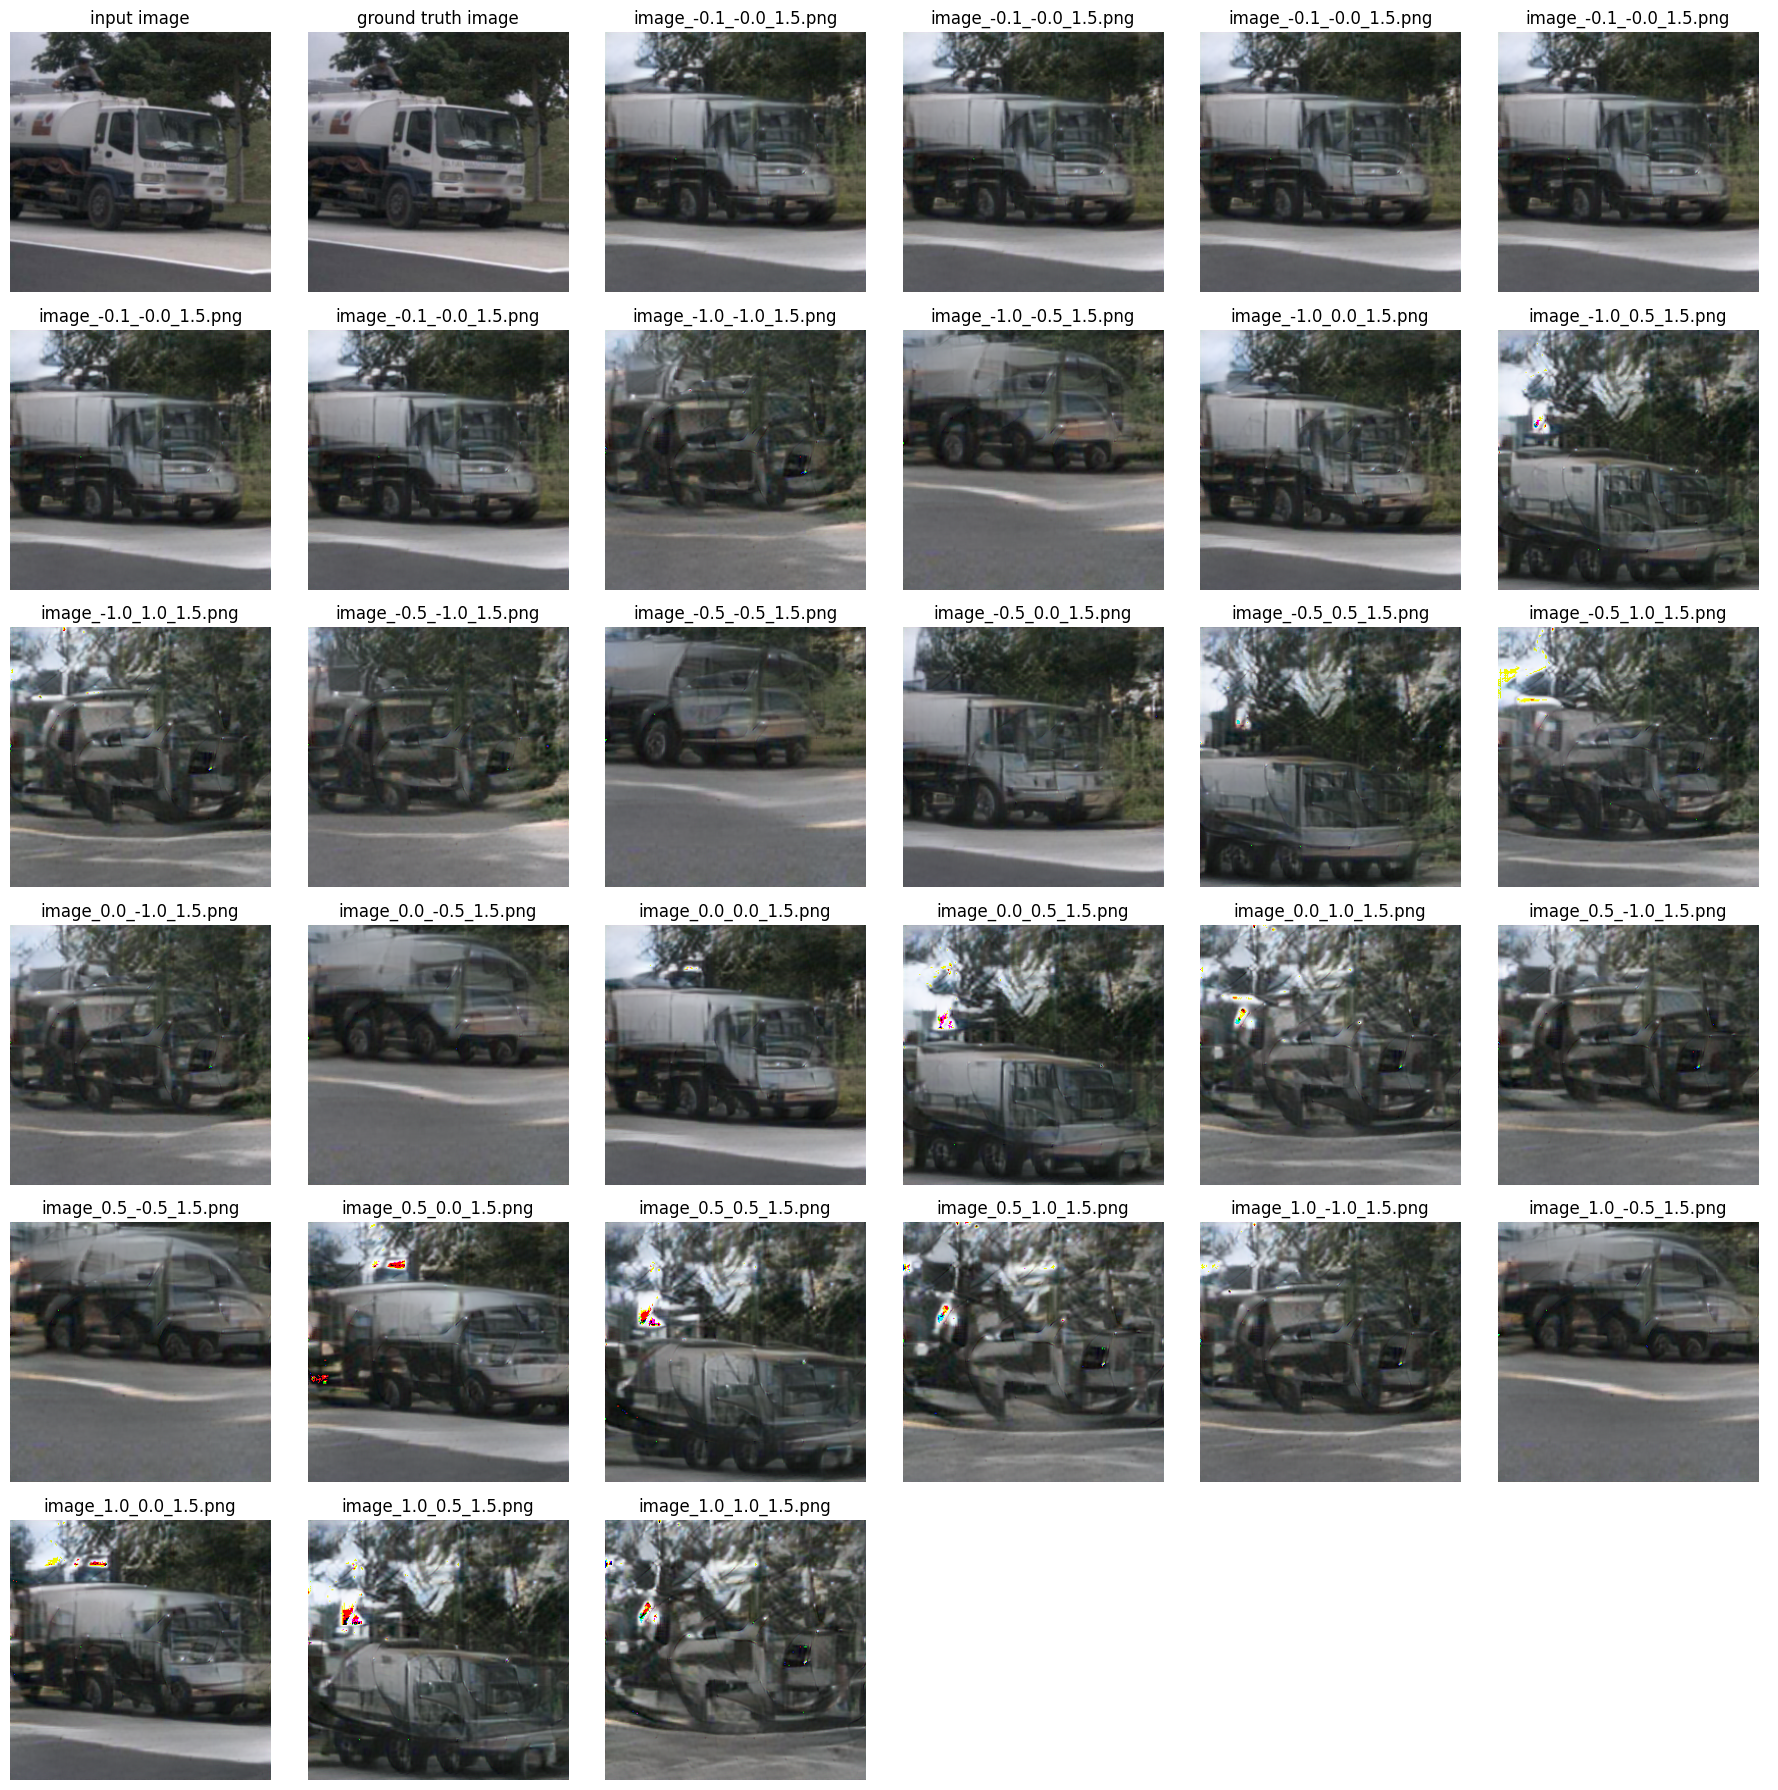

In [51]:
batch = next(iteration)

for key in batch:
    if isinstance(batch[key], float) or isinstance(batch[key], int):
        batch[key] = torch.tensor([batch[key]])
    elif isinstance(batch[key], torch.Tensor):
        batch[key] = batch[key].unsqueeze(0)
pred_obj_lists, inference_pose_lists = inference_second_pose_lists(model, batch)
save_lists_output(pred_obj_lists, inference_pose_lists)
plot_images_side_by_side(inference_pose_lists, num_images=len(pred_obj_lists))
